## Bank Fraud Models


In [79]:
!pip install opendatasets
!pip install xgboost
!pip install imbalanced-learn

In [80]:
# Importing the dataset

import opendatasets as od 

od.download("https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022/data")

Skipping, found downloaded files in ".\bank-account-fraud-dataset-neurips-2022" (use force=True to force download)


In [81]:
# Reading the dataset

import pandas as pd
data = pd.read_csv("./bank-account-fraud-dataset-neurips-2022/Base.csv")



# Data processing pipeline:

1. Feature selection
2. Separating numerical and categorical features
3. Scaling the numerical features
4. One-hot encoding the categorical features

The qualitative features we will use are income, customer age, credit risk score, proposed credit limit and name email similarity. 

For categorical features, we choose device OS, housing status and keep_alive_session.

In [82]:
# import libraries


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

X = data.drop('fraud_bool', axis = 1)
y = data['fraud_bool']

# Let's only work with a few quantitative features

features = ['income',
       'customer_age',
       'credit_risk_score', 'proposed_credit_limit', 'name_email_similarity']


# Scaling data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[features])
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=X.index)

# Add some categorical features

cat = ['device_os','housing_status', 'keep_alive_session']

# One hot encode them

X_cat_encode = pd.get_dummies(X[cat], drop_first=True, columns= cat)

X_new = pd.concat([X_scaled_df,X_cat_encode], axis = 1)






We do a stratified train-test split on the data and use SMOTE to generate more samples of the minority class since the data is highly unbalanced. 

In [83]:
x_train, x_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.1, stratify=y , random_state=42)

smote = SMOTE(random_state=48)
x_resampled, y_resampled = smote.fit_resample(x_train, y_train)


# Models:

1. Logistic regression for various cutoff values
2. Logistic regression after PCA transformation for various cutoffs
3. Gaussian Naive Bayes for numerical data
4. Stacked model - Gaussian Naive Bayes on numerical data + Bernuolli Naive Bayes for categorical 
4. XGBoost?

We start off with the logistic regression model and compare the recall, precision and F1 scores for various cut offs

In [84]:
# Logistic regression

from sklearn.linear_model import LogisticRegression

reg_model = LogisticRegression( 
    random_state=42)
reg_model.fit(x_resampled, y_resampled)

LogisticRegression(random_state=42)

We vary the cutoff scores from 0 to 1 in the intervals of 0.01 and compute the recall and precision scores

In [85]:


recall = []
precision = [] 
threshold = np.arange(0.0,1.0,0.01)

for i in threshold:
    y_out = reg_model.predict_proba(x_test)[:, 1]
    y_pred = (y_out >= i).astype(int)
    cofm = confusion_matrix(y_test, y_pred)
    r = cofm[1][1]/(cofm[1][1] + cofm[1][0])
    p = cofm[1][1]/(cofm[1][1]+cofm[0][1])
    recall.append(r)
    precision.append(p)
    



C:\Users\arpit\AppData\Local\Temp\ipykernel_21332\2118879487.py:10: RuntimeWarning: invalid value encountered in scalar divide
  p = cofm[1][1]/(cofm[1][1]+cofm[0][1])
C:\Users\arpit\AppData\Local\Temp\ipykernel_21332\2118879487.py:10: RuntimeWarning: invalid value encountered in scalar divide
  p = cofm[1][1]/(cofm[1][1]+cofm[0][1])


Let's plot the recall and precision scores for the various cutoffs

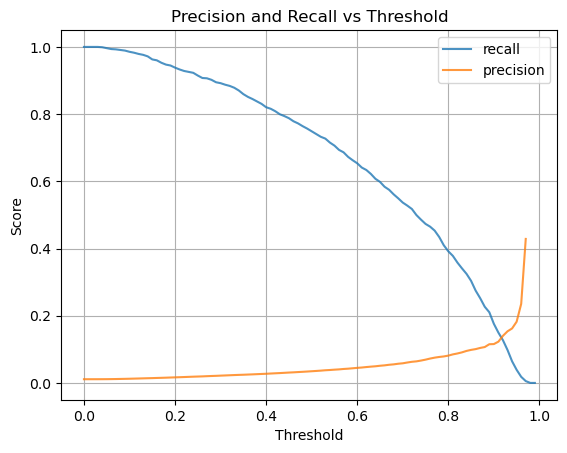

In [86]:


sns.lineplot(x = threshold, y = recall, alpha=0.8, label = 'recall')
sns.lineplot(x = threshold, y = precision, alpha = 0.8, label = 'precision')


plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.grid(True)
plt.legend()
plt.show()


As we can see, this model has around 70% recall for cutoff of 0.5 but the precision is poor and doesn't seem to rise much expect when cutoff is close to 1 in which case recall is pretty much 0. This is shown by the precision vs recall curve below! 

C:\Users\arpit\AppData\Local\Temp\ipykernel_21332\3026048146.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


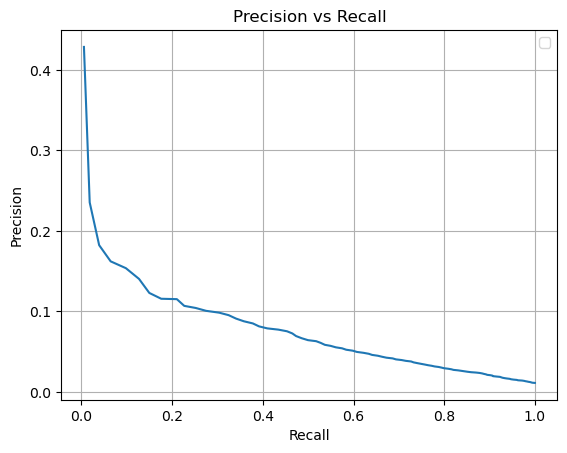

In [87]:
sns.lineplot(x=recall, y=precision)


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.grid(True)
plt.legend()
plt.show()


Here is the F1 score for various cutoffs

C:\Users\arpit\AppData\Local\Temp\ipykernel_21332\3459120465.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


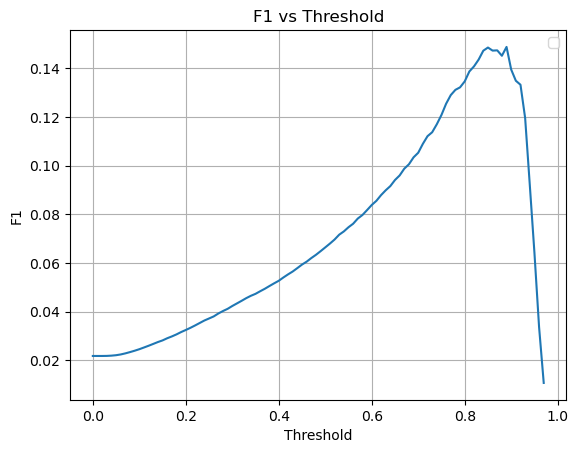

In [88]:
prec = np.array(precision)
rec = np.array(recall)

F1 = 2*prec*rec/(prec+rec)


sns.lineplot(x=threshold,y=F1)

plt.xlabel('Threshold')
plt.ylabel('F1')
plt.title('F1 vs Threshold')
plt.grid(True)
plt.legend()
plt.show()



Now we use PCA to transform the data and run the same model to see the changes in the scores


In [89]:
from sklearn.decomposition import PCA

X_num = data.select_dtypes(include = [np.number])
X_num = X_num.drop(columns = ['fraud_bool'])
X_num_scaled = scaler.fit_transform(X_num)


pca = PCA(0.95)
X_pca = pca.fit_transform(X_num_scaled)

X_pca_new = np.hstack((X_pca, X_cat_encode.values))

# Train-test split

x_pca_train, x_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca_new, y, test_size = 0.1, stratify=y , random_state=42)

# Generating Synthetic samples

smote = SMOTE(random_state=48)
x_pca_resampled, y_pca_resampled = smote.fit_resample(x_pca_train, y_pca_train)



In [90]:
pca_reg_model = LogisticRegression( 
    random_state=42)
pca_reg_model.fit(x_pca_resampled, y_pca_resampled)

LogisticRegression(random_state=42)

In [91]:
recall1 = []
precision1 = [] 
threshold = np.arange(0.0,1.0,0.01)

for i in threshold:
    y_out = pca_reg_model.predict_proba(x_pca_test)[:, 1]
    y_pred = (y_out >= i).astype(int)
    cofm = confusion_matrix(y_pca_test, y_pred)
    r = cofm[1][1]/(cofm[1][1] + cofm[1][0])
    p = cofm[1][1]/(cofm[1][1]+cofm[0][1])
    recall1.append(r)
    precision1.append(p)

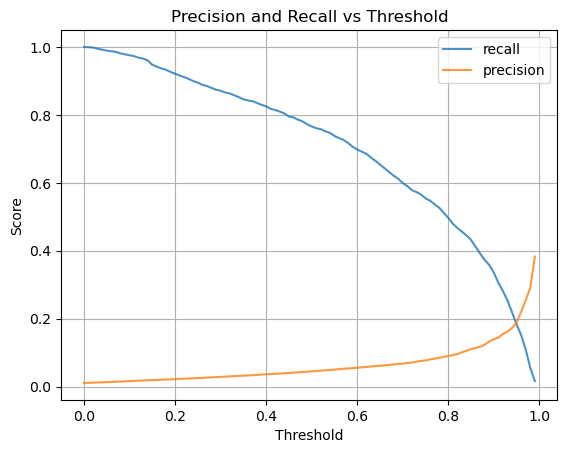

In [92]:
sns.lineplot(x = threshold, y = recall1, alpha=0.8, label = 'recall')
sns.lineplot(x = threshold, y = precision1, alpha = 0.8, label = 'precision')


plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.grid(True)
plt.legend()
plt.show()


C:\Users\arpit\AppData\Local\Temp\ipykernel_21332\2852192847.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


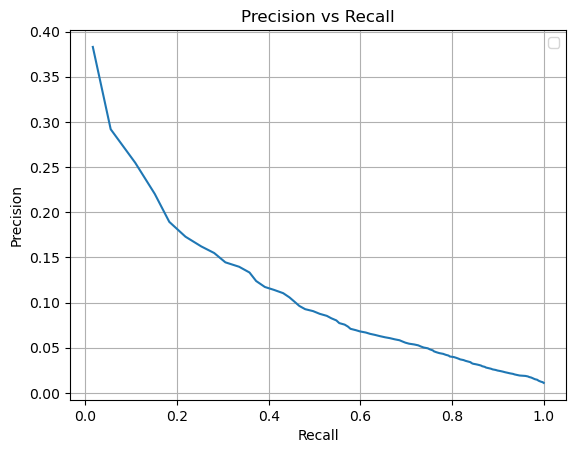

In [93]:
sns.lineplot(x=recall1, y=precision1)


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.grid(True)
plt.legend()
plt.show()


C:\Users\arpit\AppData\Local\Temp\ipykernel_21332\3734420800.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


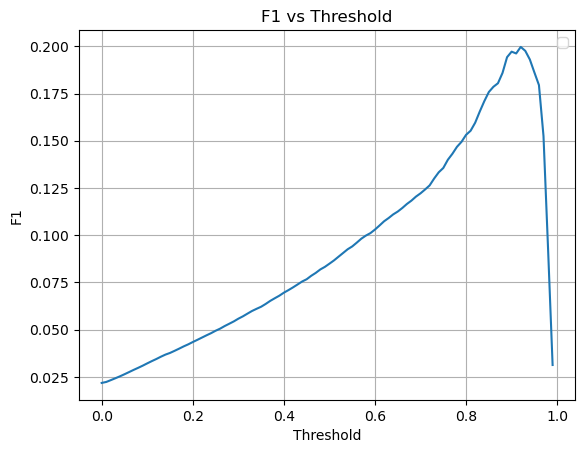

In [94]:
prec1 = np.array(precision1)
rec1 = np.array(recall1)

F1 = 2*prec1*rec1/(prec1+rec1)


sns.lineplot(x=threshold,y=F1)

plt.xlabel('Threshold')
plt.ylabel('F1')
plt.title('F1 vs Threshold')
plt.grid(True)
plt.legend()
plt.show()



Let's compare the PCA vs non PCA results:


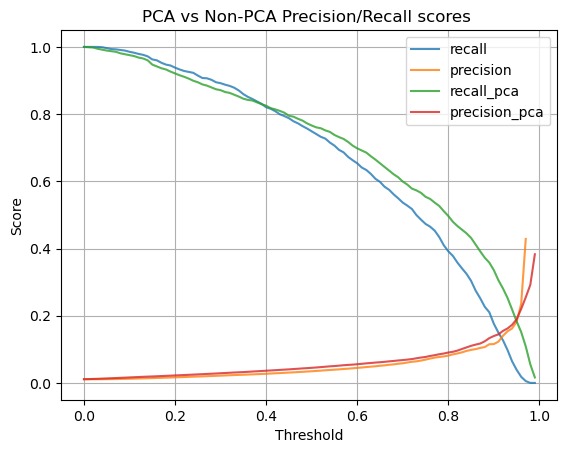

In [95]:
sns.lineplot(x = threshold, y = recall, alpha=0.8, label = 'recall')
sns.lineplot(x = threshold, y = precision, alpha = 0.8, label = 'precision')
sns.lineplot(x = threshold, y = recall1, alpha=0.8, label = 'recall_pca')
sns.lineplot(x = threshold, y = precision1, alpha = 0.8, label = 'precision_pca')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('PCA vs Non-PCA Precision/Recall scores ')
plt.grid(True)
plt.legend()
plt.show()




We can see that PCA transformed data has slightly better recall scores compared to non PCA data even though the precision is the same

In [96]:
#Fitting Gaussian for Numerical variables

model = GaussianNB()
model.fit(x_pca_resampled[:, :21], y_pca_resampled)

y_out = model.predict_proba(x_pca_test[:, :21])[:, 1]
print(y_out)

[0.22919098 0.49116584 0.06141704 ... 0.66462589 0.05466413 0.08842545]


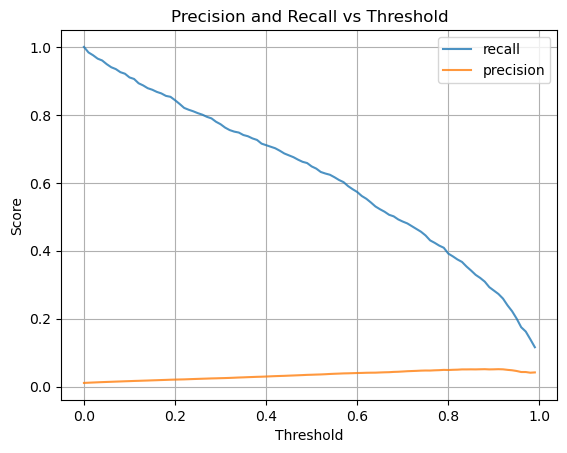

In [97]:
recall2 = []
precision2 = [] 
threshold = np.arange(0.0,1.0,0.01)

for i in threshold:
    y_out = model.predict_proba(x_pca_test[:, :21])[:, 1]
    y_pred = (y_out >= i).astype(int)
    cofm = confusion_matrix(y_pca_test, y_pred)
    r = cofm[1][1]/(cofm[1][1] + cofm[1][0])
    p = cofm[1][1]/(cofm[1][1]+cofm[0][1])
    recall2.append(r)
    precision2.append(p)
    

sns.lineplot(x = threshold, y = recall2, alpha=0.8, label = 'recall')
sns.lineplot(x = threshold, y = precision2, alpha = 0.8, label = 'precision')


plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.grid(True)
plt.legend()
plt.show()


In [132]:
# Let's try XGBoost
from xgboost import XGBClassifier

model_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=90,  
    use_label_encoder=False,
    objective='binary:logistic',
    eval_metric='auc'
)

model_xgb.fit(x_pca_train, y_pca_train)

# Predict probabilities
y_proba = model_xgb.predict_proba(x_pca_test)[:, 1]  # probability of fraud (class 1)



c:\Users\arpit\anaconda3\envs\erdos_spring_2025\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:15:11] WARNING: D:\bld\xgboost-split_1737698232980\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


C:\Users\arpit\AppData\Local\Temp\ipykernel_21332\1405192834.py:10: RuntimeWarning: invalid value encountered in scalar divide
  p = cofm[1][1]/(cofm[1][1]+cofm[0][1])


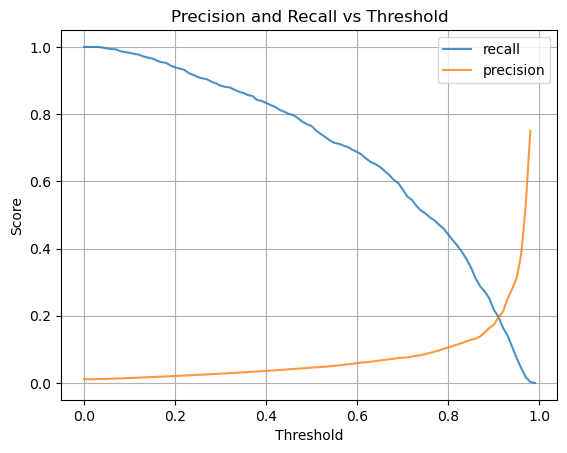

In [133]:
recall_xgb = []
precision_xgb = [] 
threshold = np.arange(0.0,1.0,0.01)

for i in threshold:
    y_out = model_xgb.predict_proba(x_pca_test)[:, 1]
    y_pred = (y_out >= i).astype(int)
    cofm = confusion_matrix(y_pca_test, y_pred)
    r = cofm[1][1]/(cofm[1][1] + cofm[1][0])
    p = cofm[1][1]/(cofm[1][1]+cofm[0][1])
    recall_xgb.append(r)
    precision_xgb.append(p)
    

sns.lineplot(x = threshold, y = recall_xgb, alpha=0.8, label = 'recall')
sns.lineplot(x = threshold, y = precision_xgb, alpha = 0.8, label = 'precision')


plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.grid(True)
plt.legend()
plt.show()








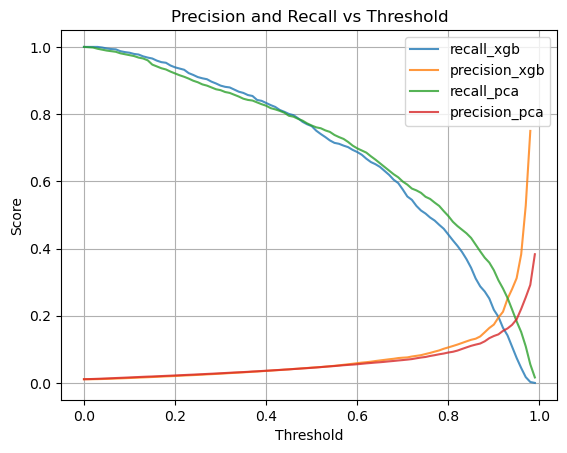

In [134]:
sns.lineplot(x = threshold, y = recall_xgb, alpha=0.8, label = 'recall_xgb')
sns.lineplot(x = threshold, y = precision_xgb, alpha = 0.8, label = 'precision_xgb')

sns.lineplot(x = threshold, y = recall1, alpha=0.8, label = 'recall_pca')
sns.lineplot(x = threshold, y = precision1, alpha = 0.8, label = 'precision_pca')


plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.grid(True)
plt.legend()
plt.show()
